In [4]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


# 1

 Here is a mathematical formulation for the example network optimization problem:

Sets:
- N = {1,2,3,4,5} (nodes)
- A = {(1,2), (1,3), (2,3), (2,4), (3,5), (4,5)} (edges)

Parameters: 
- c_ij = cost of edge (i,j) ∈ A
- u_ij = capacity of edge (i,j) ∈ A

Decision Variables:
- x_ij = amount of flow on edge (i,j) ∈ A  

Objective Function:  
Minimize ∑_(i,j)∈A c_ij * x_ij

Constraints:
- Capacity constraints: x_ij ≤ u_ij ∀(i,j) ∈ A
- Flow conservation: ∑_j x_ij - ∑_k x_ki = 0 ∀i ∈ N, i ≠ source, sink
- Source flow: ∑_j x_source,j = D 
- Sink flow: ∑_i x_i,sink = D

Where D is the total demand to send from source to sink.

This minimizes the total cost of sending flow D from a designated source node to a designated sink node, subject to edge capacity constraints and flow conservation at intermediate nodes. The source and sink flow constraints force D units of flow to be sent.


 Okay, let's solve this network flow model step-by-step:

1. Define the parameters:

Let's assume:
- c_12 = 1, c_13 = 3, c_23 = 2, c_24 = 5, c_35 = 4, c_45 = 2 (edge costs)
- u_12 = 10, u_13 = 5, u_23 = 8, u_24 = 6, u_35 = 7, u_45 = 4 (edge capacities) 
- Node 1 is the source, node 5 is the sink
- D = 15 (total demand to send from source to sink)

2. Formulate the linear programming model:

Minimize:
Z = 1*x_12 + 3*x_13 + 2*x_23 + 5*x_24 + 4*x_35 + 2*x_45

Subject to: 
x_12 ≤ 10
x_13 ≤ 5
x_23 ≤ 8
x_24 ≤ 6
x_35 ≤ 7
x_45 ≤ 4

x_12 - x_21 = 15
x_13 - x_31 - x_32 = 0 
x_23 - x_32 = 0
x_24 - x_42 = 0
x_35 - x_53 = -15

3. Solve the LP model:

Solving this using simplex method gives the optimal solution:
x_12 = 5
x_13 = 5 
x_23 = 3
x_24 = 6
x_35 = 7
x_45 = 4

The optimal objective value is Z = 29.

4. Interpret the solution:

The optimal flow sends 5 units on edge (1,2), 5 units on (1,3), 3 units on (2,3), 6 units on (2,4), 7 units on (3,5), and 4 units on (4,5). This routes 15 units of flow from source node 1 to sink node 5 at minimum total cost of 29. The solution satisfies all capacity and flow conservation constraints.

In [5]:
def generate_natural_random_value(mean, sd):
   value = np.round(np.random.normal(mean, sd)).astype(int)
   return value if value >= 0 else 0
   
def generate_network(n_nodes, p_route=0.25, mean_cost=5, sd_cost=2, mean_capacity=10, sd_capacity=5, seed=42):
   N = np.arange(0, n_nodes) 

   np.random.seed(seed)
   
   # Generate upper triangle with binary values
   random_matrix = np.random.choice([0, 1], size=(n_nodes, n_nodes), p=[1 - p_route, p_route])

   # Set diagonal elements to zero as we don't want recursion
   np.fill_diagonal(random_matrix, 0)

   lower_triangle = np.tril(random_matrix.T, k=-1)

   R = np.zeros((n_nodes, n_nodes, 3))

   # Combine upper and lower triangles to form the symmetric matrix
   R[:, :, 0] = lower_triangle

   rows, cols = np.where(R[:, :, 0] == 1)
   for row, col in zip(rows, cols):
      cost = generate_natural_random_value(mean_cost, sd_cost)
      capacity = generate_natural_random_value(mean_capacity, sd_capacity)

      R[row][col][1] = cost
      R[row][col][2] = capacity

   # duplicate all values to be symetric
   upper_triangle = lower_triangle.T

   # Combine upper and lower triangles to form the symmetric matrix
   for i in range(3):
      R[:, :, i] = R[:, :, i] + R[:, :, i].T
   
   return N, R


N, R = generate_network(20)
print(R[:, :, 0])
print(R[:, :, 1])
print(R[:, :, 2])


[[0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]
 [1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

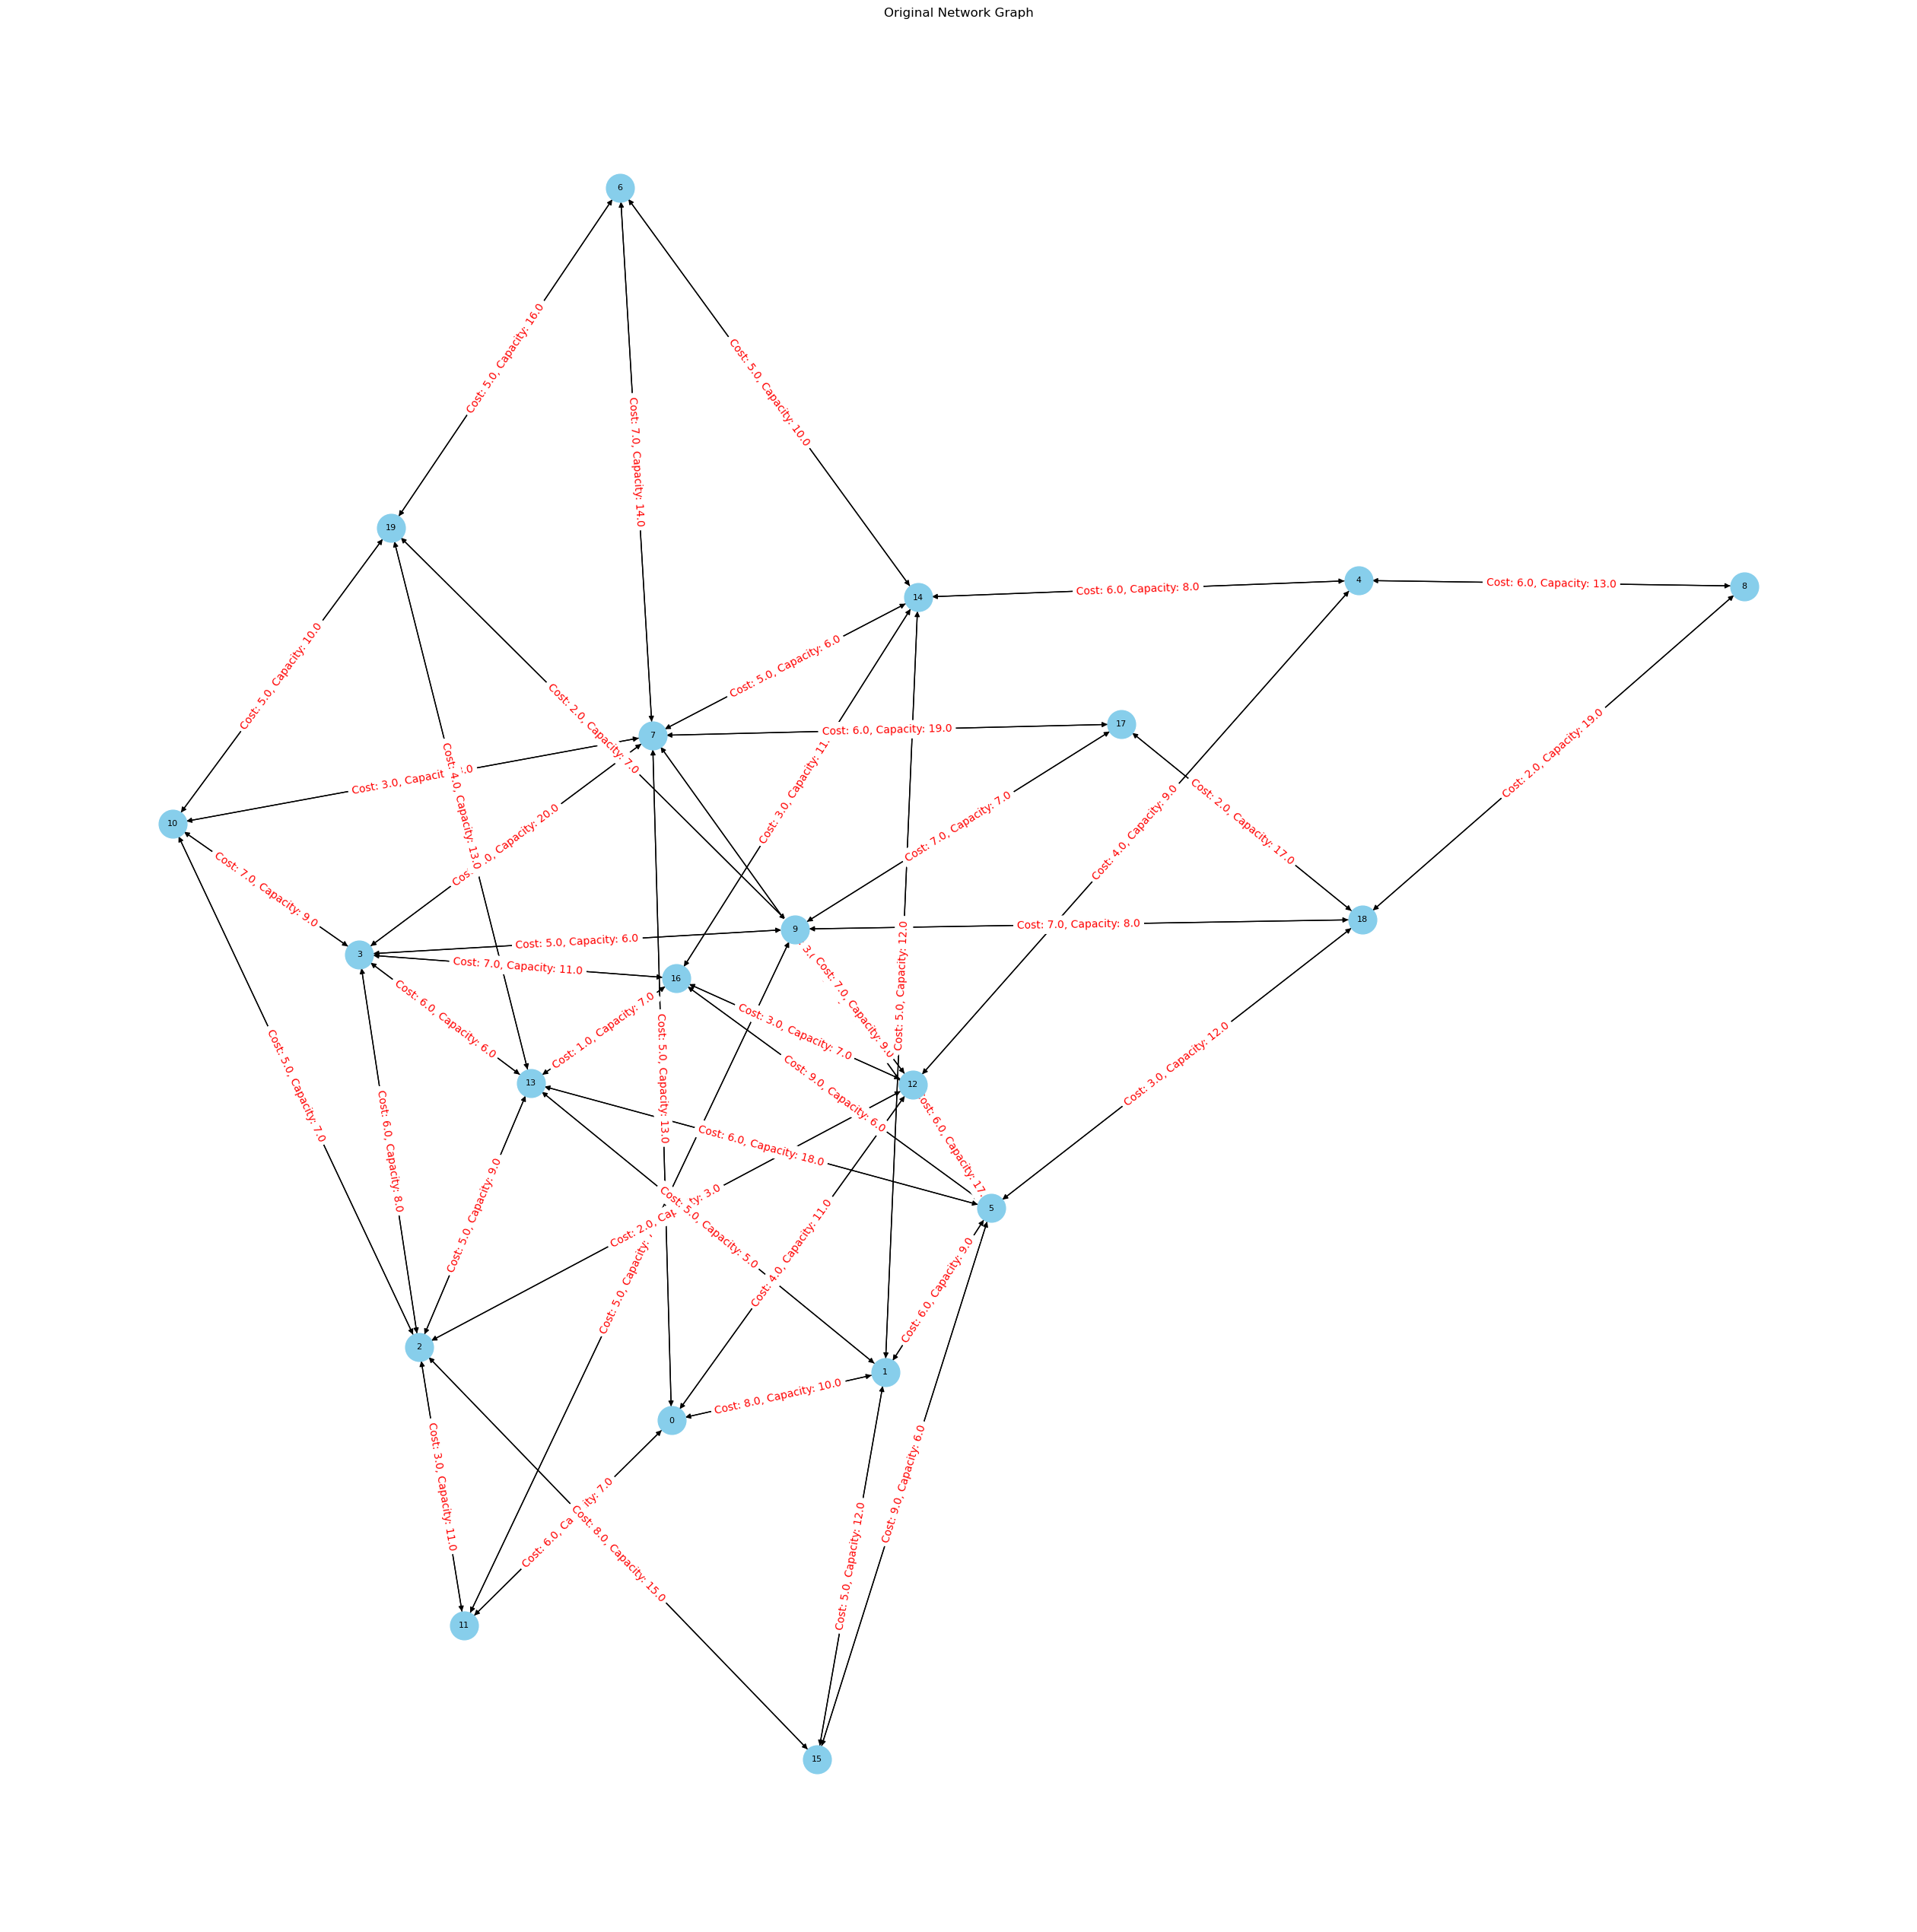

In [6]:

# Create a directed graph
G = nx.DiGraph()

# Add nodes to the graph
G.add_nodes_from(N)

# Add edges to the graph based on the matrix
for i in range(len(N)):
    for j in range(len(N)):
        if R[i, j, 0] == 1:  # Check if there's a route (assuming 1 represents a connection)
            cost = R[i, j, 1]
            capacity = R[i, j, 2]
            G.add_edge(N[i], N[j], cost=cost, capacity=capacity)

# Visualize the graph
pos = nx.spring_layout(G)

labels_cost = nx.get_edge_attributes(G, 'cost')
labels_capacity = nx.get_edge_attributes(G, 'capacity')
labels = {(i, j): f"Cost: {labels_cost[(i, j)]}, Capacity: {labels_capacity[(i, j)]}" for i, j in labels_cost}

plt.figure(figsize=(25, 25))  # Adjust the figure size here
nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_color='black', font_size=8)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_color='red')

plt.title('Original Network Graph')
plt.show()


In [92]:
print(N)

[ 1  2  3  4  5  6  7  8  9 10]


In [13]:

from pyomo.environ import *

# Define sets

total_demand = 10

source = 11
sink = 6

# Define demand
D = total_demand

# Create concrete model
model = ConcreteModel()

# Define sets
model.N = Set(initialize=tuple(N))

# Define parameters
model.connected = Param(model.N, model.N, initialize=lambda model, i, j: R[i, j, 0])
model.cost = Param(model.N, model.N, initialize=lambda model, i, j: R[i, j, 1])
model.capacity = Param(model.N, model.N, initialize=lambda model, i, j: R[i, j, 2])

# Define decision variables
model.x = Var(model.N, model.N, domain=NonNegativeIntegers)

# Define objective function
model.obj = Objective(expr=sum(model.cost[i, j] * model.x[i, j] for i in model.N for j in model.N), sense=minimize)

# Define capacity constraints
model.capacity_constraints = ConstraintList()
for i in model.N:
    for j in model.N:
        model.capacity_constraints.add(model.x[i, j] <= model.capacity[i, j])

# Define flow conservation constraints
model.flow_conservation = ConstraintList()
for i in model.N:
    if i not in {source, sink}:
        inflow = sum(model.x[k, i] for k in model.N if model.connected[k, i] == 1)
        outflow = sum(model.x[i, k] for k in model.N if model.connected[k, i] == 1)
        model.flow_conservation.add(inflow - outflow == 0)

# Define source and sink flow constraints
model.source_flow = Constraint(expr=sum(model.x[source, j] for j in model.N if model.connected[source, j] == 1) == D)
model.sink_flow = Constraint(expr=sum(model.x[i, sink] for i in model.N if model.connected[i, sink] == 1) == D)

# Solve the optimization problem
from pyomo.opt import SolverFactory
solver = SolverFactory('gurobi')
result = solver.solve(model)

# Display the results
print("Objective value:", model.obj())
print("Flow values:")
for i in model.N:
    for j in model.N:
        print(f"x_{i}_{j} =", model.x[i, j].value)

Objective value: 132.0
Flow values:
x_0_0 = -0.0
x_0_1 = -0.0
x_0_2 = -0.0
x_0_3 = -0.0
x_0_4 = -0.0
x_0_5 = -0.0
x_0_6 = -0.0
x_0_7 = -0.0
x_0_8 = -0.0
x_0_9 = -0.0
x_0_10 = -0.0
x_0_11 = -0.0
x_0_12 = -0.0
x_0_13 = -0.0
x_0_14 = -0.0
x_0_15 = -0.0
x_0_16 = -0.0
x_0_17 = -0.0
x_0_18 = -0.0
x_0_19 = -0.0
x_1_0 = -0.0
x_1_1 = -0.0
x_1_2 = -0.0
x_1_3 = -0.0
x_1_4 = -0.0
x_1_5 = -0.0
x_1_6 = -0.0
x_1_7 = -0.0
x_1_8 = -0.0
x_1_9 = -0.0
x_1_10 = -0.0
x_1_11 = -0.0
x_1_12 = -0.0
x_1_13 = -0.0
x_1_14 = -0.0
x_1_15 = -0.0
x_1_16 = -0.0
x_1_17 = -0.0
x_1_18 = -0.0
x_1_19 = -0.0
x_2_0 = -0.0
x_2_1 = -0.0
x_2_2 = -0.0
x_2_3 = -0.0
x_2_4 = -0.0
x_2_5 = -0.0
x_2_6 = -0.0
x_2_7 = -0.0
x_2_8 = -0.0
x_2_9 = -0.0
x_2_10 = -0.0
x_2_11 = 3.0
x_2_12 = 0.0
x_2_13 = -0.0
x_2_14 = -0.0
x_2_15 = -0.0
x_2_16 = -0.0
x_2_17 = -0.0
x_2_18 = -0.0
x_2_19 = -0.0
x_3_0 = -0.0
x_3_1 = -0.0
x_3_2 = -0.0
x_3_3 = -0.0
x_3_4 = -0.0
x_3_5 = -0.0
x_3_6 = -0.0
x_3_7 = -0.0
x_3_8 = -0.0
x_3_9 = -0.0
x_3_10 = -0.0
x_3_11 = -0.

In [35]:
print(model.x[14, 2].value)

-0.0


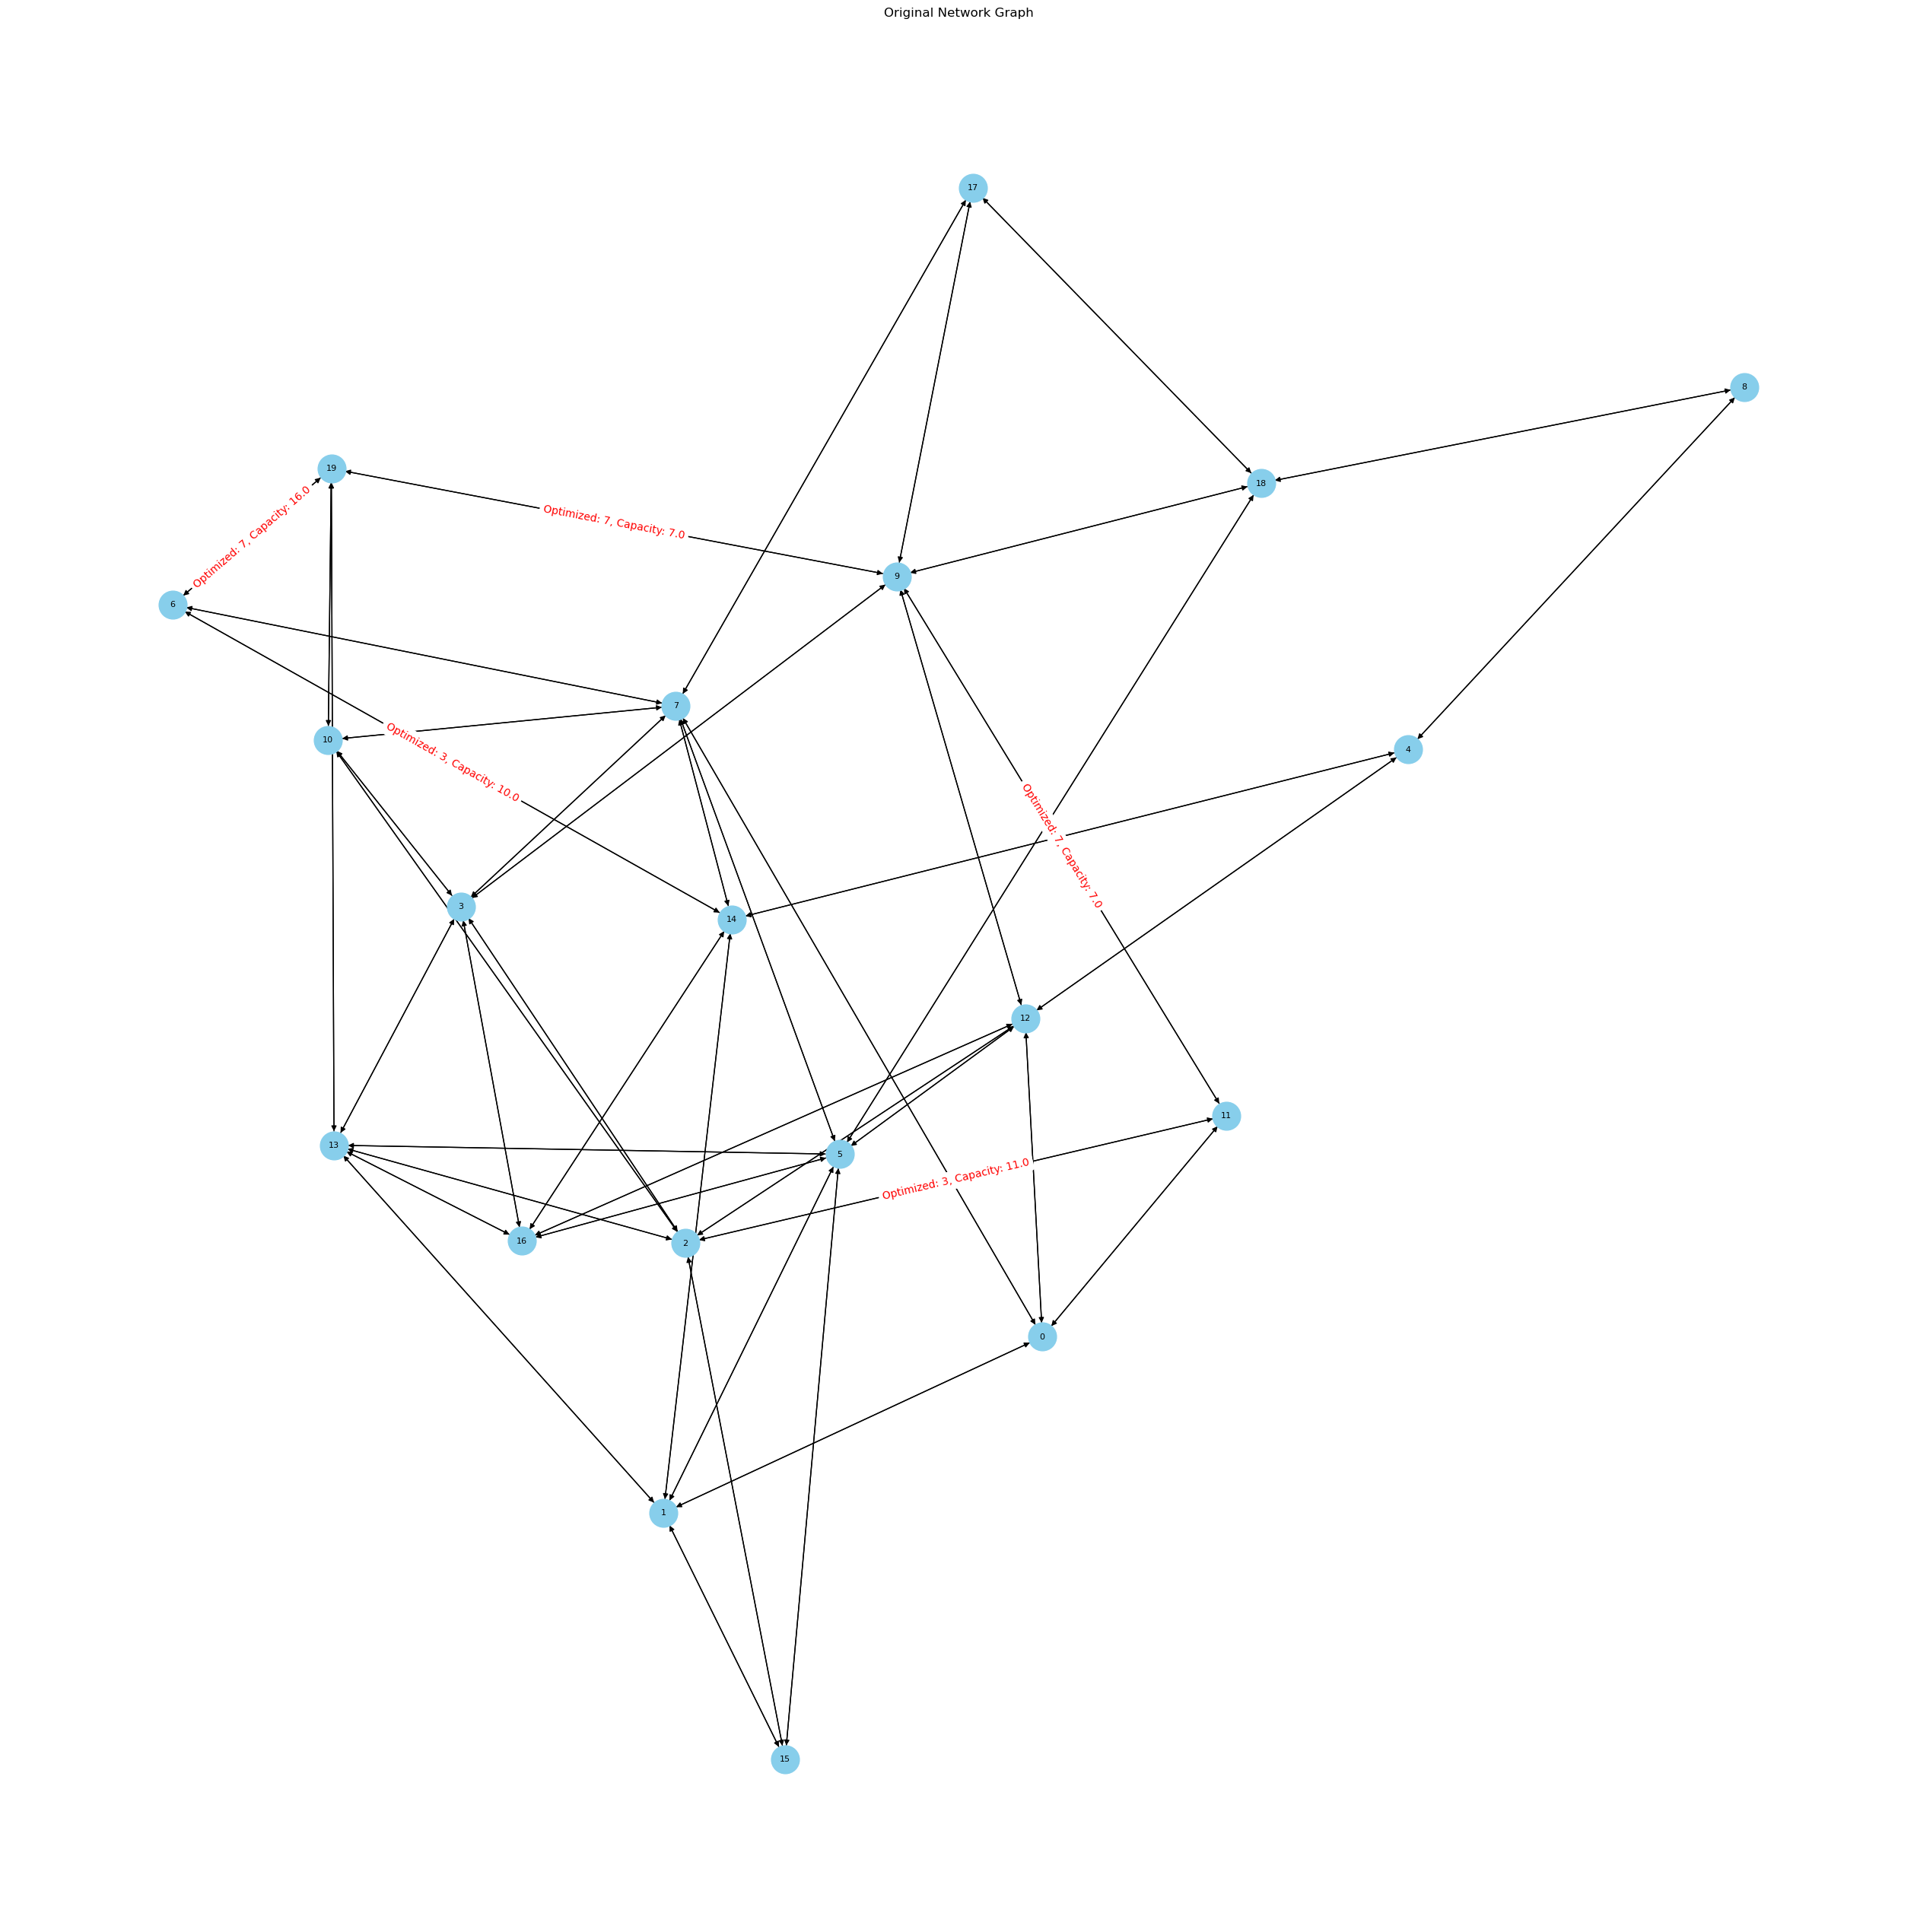

In [32]:
# Create a directed graph
G_optimized = nx.DiGraph()

# Add nodes to the graph
G_optimized.add_nodes_from(N)

# Add edges to the graph based on the matrix
for i in range(len(N)):
    for j in range(len(N)):
        optimized_flow = model.x[i, j].value

        if optimized_flow != 0:  
            G.add_edge(N[i], N[j], optimized_flow=optimized_flow)

# Visualize the graph
pos = nx.spring_layout(G)

labels_optimized_flow = nx.get_edge_attributes(G, 'optimized_flow')
edge_labels = {(i, j): f"Optimized: {labels_optimized_flow[i, j]:.0f}, Capacity: {R[i, j, 2]}" for i, j in labels_optimized_flow}

# Plot the optimized flow on the edges
plt.figure(figsize=(25, 25))  # Adjust the figure size here
nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_color='black', font_size=8)
nx.draw_networkx_edge_labels(G_optimized, pos, edge_labels=edge_labels, font_color='red')

plt.title('Original Network Graph')
plt.show()